# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import csv
from sklearn.utils import shuffle
import matplotlib.gridspec as gridspec
%matplotlib inline

training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

#Load training and testing pickle files
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
# Data exploration 

n_train = len(X_train)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(set(y_train))
n_classes_test= len(set(y_test))
image_shape_y_train = y_train[1].shape
image_shape_y_test = y_test.shape

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print("Number of classes_test =", n_classes_test)
print("Number of classes_y_train =", y_train)
print("Number of classes_y_test =", y_test)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Number of classes_test = 43
Number of classes_y_train = [ 0  0  0 ..., 42 42 42]
Number of classes_y_test = [16  1 38 ...,  6  7 10]


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The TrafficClassifier-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

0


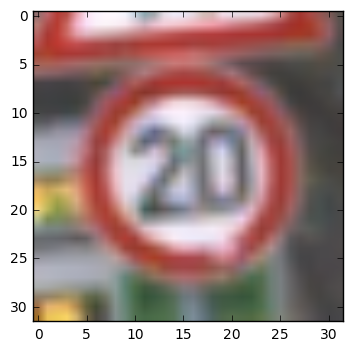

In [3]:
#Plot one of the image (just to get started)
plt.imshow(X_train[10])
print (y_train[10])

In [4]:
# Function to read signnames.csv file provided in the project; 
# each row contains a classid and corresponding signal name, example: class id: 5 corresponds to Speed limit (80km/h)

def signal_names_reader(value):
    signnames_classifications = []
   
    with open('./signnames.csv', 'r') as csvfile:
        signnames_reader = csv.reader(csvfile)
        
        for row in signnames_reader:
            signnames_classifications.append(row[1]) #row[0]is class id and row [1] is signal name
        signnames_classifications = signnames_classifications[1:] #ignore first row as it is a title
        
        return signnames_classifications[value]

In [5]:
# Helper function to plot images
def plot_images(num_of_images, image_num,X,Y):
    for i in range(num_of_images):
        ax=plt.subplot(2,2,i+1) #create a subplot

        plt.subplots_adjust(hspace = 0.8,wspace=2.0) #adjust height between sublots so that plots/lables don't overlap
        plt.axis('off')
        plt.imshow(X[i+image_num]) #plot image of some random number
        value = Y[i+image_num] #print corresponding label
        label= signal_names_reader(value) #call the function to read csv file and fetch correct signal name
        ax.set_title(label) #set label

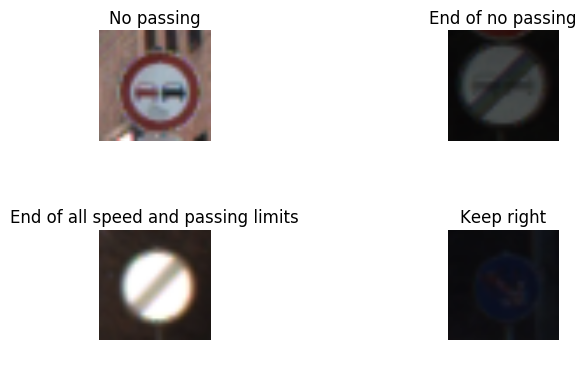

In [6]:
# Plot four sample images
X_train, y_train = shuffle(X_train, y_train, random_state=7) #shuffle the data
plot_images(4,100,X_train,y_train)


In [7]:
#make a copy of original data set, this will come handy later while creating additioanl data sets
X_train_org = X_train
y_train_org=y_train

In [8]:
# Below code is from carnd forum which talks about image transformation with more details: 
# https://carnd-forums.udacity.com/display/CAR/Project+2+%28unbalanced+data%29+Generating+additional+data+by+jittering+the+original+image
# More details: http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range,brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation: Translation is the shifting of object’s location. 
    # In affine transformation, all parallel lines in the original image will still be parallel in the output image.
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)
    
    #Transform image using above parameters
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    if brightness == 1:
        img = augment_brightness_camera_images(img)
    return img


In [9]:
# code to generate new images using transformation function above from data set

x_more=[]
y_more = []
num_newImages = 1000 #set number of additional images required

for j in range (num_newImages):
    image = X_train[j]
    val = y_train[j]
    for i in range(4):
        img = transform_image(image,20,10,5,brightness=0) #call transform image function
        x_more.append(img)
        y_more.append(val)


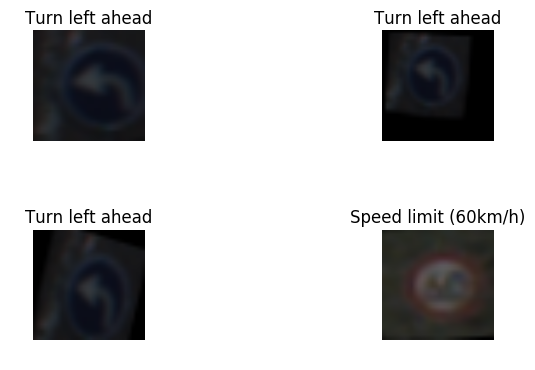

In [10]:
#Generate few sample images after transformation
plot_images(4, 209,x_more,y_more) #plot image of some random number #209

43209
4000


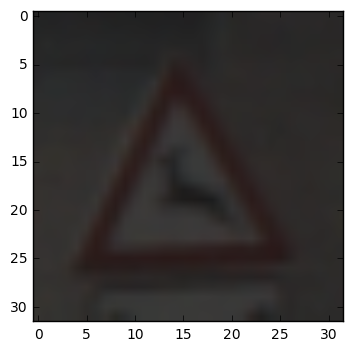

In [11]:
# Code to merge generated new images into original data set
X_train=X_train_org #copy original image data set
y_train=y_train_org #copy original label data set

X_train=np.vstack((X_train,x_more)) #merge newly generated data set using np.vstack (row wise stacking)
y_train=np.append(y_train,y_more)

print (len(X_train)) #length of new training set (this should be X_train_org + x_more)
print (len(x_more)) #lenght of newly generated images

plt.imshow(X_train[9208]) #plot last image; just for verification


In [12]:
# def transformation (img):
#     rows,cols,ch = img.shape
    
#     pts1 = np.float32([[10,10],[25,10],[20,15]])
#     pts2 = np.float32([[9,11],[24,11],[19,16]])
#     M = cv2.getAffineTransform(pts1,pts2)
#     dst = cv2.warpAffine(img,M,(cols,rows))
    
#     pts1 = np.float32([[5,7],[25,7],[5,28],[25,25]])
#     pts2 = np.float32([[0,0],[30,0],[0,30],[30,30]])
#     M = cv2.getPerspectiveTransform(pts1,pts2)
#     dst = cv2.warpPerspective(img,M,(32,32))

#     return dst

# X_trainT=X_train
# y_trainT=[]

# x=int(n_train/2) #transform only half of images

# for j in range(x):
#     X_train[j]=transformation(X_train[j])
    
# plt.imshow(X_train[10])
# print (y_train[10])


In [13]:
#Re-run stats to make sure:1. Data is shuffled 2. All stats are correct

n_train = len(X_train)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(set(y_train))
n_classes_test= len(set(y_test))
image_shape_y_train = y_train[1].shape
image_shape_y_test = y_test.shape

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print("Number of classes_test =", n_classes_test)
print("Number of classes_y_train =", y_train)
print("Number of classes_y_test =", y_test)

Number of training examples = 43209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Number of classes_test = 43
Number of classes_y_train = [17 11 18 ..., 38 38 38]
Number of classes_y_test = [16  1 38 ...,  6  7 10]


### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [14]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# from sklearn.utils import shuffle
# X_train, y_train = shuffle(X_train, y_train, random_state=7)

# X_train_orig = X_train
# X_test_orig = X_test

# # Standardization 
# X_train_std = (X_train - X_train.mean()) / np.std(X_train)
# X_test_std = (X_test - X_test.mean()) /np.std(X_test)

# # Normalisation
# X_train_norm = (X_train - X_train.mean()) / (np.max(X_train) - np.min(X_train))
# X_test_norm = (X_test - X_test.mean()) / (np.max(X_test) - np.min(X_test))

In [15]:
#Function to normalize data
def normalize(data):
    a = 0.01
    b = 0.99
    color_min = 0.0
    color_max = 255.0
    return a + ((data - color_min) * (b-a))/(color_max - color_min)

In [16]:
#normalize training and testing data
X_train = normalize(X_train)
X_test= normalize(X_test)

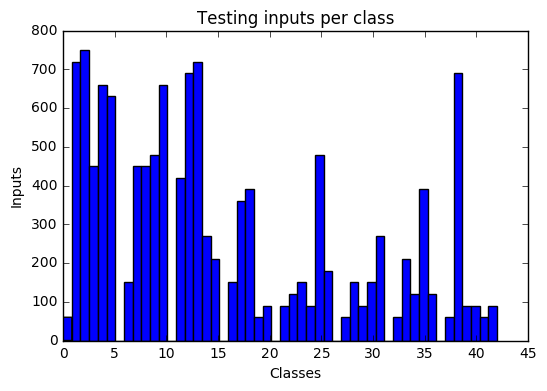

In [17]:
# Plot testing label set
plt.hist(y_test,50)
plt.xlabel('Classes')
plt.ylabel('Inputs')
plt.title('Testing inputs per class')
plt.show()

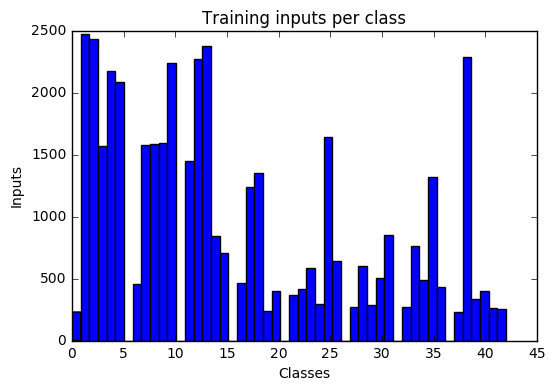

In [18]:
# Plot training label set
plt.hist(y_train,50)
plt.xlabel('Classes')
plt.ylabel('Inputs')
plt.title('Training inputs per class')
plt.show()

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
1. I shuffled the data as labels were in a sequence
2. I normalized the data to be in between 0-1; normalization is done so that we don't weigh towards a particular feature and also I didn't want to consider any outliers.
3. I transformed the data using helper function (for jitteriness, randomness and transformation) and created a new data set with more images (4000 new images in this case)



In [19]:
#Split training data into training and validation
from sklearn.model_selection import train_test_split

X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=2)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
1. I split the data into training and validation; so that I have a set to test the pipeline and avoid overfitting before running it on test data.
2. I transformed the data using helper function (to cause jitteriness, randomness and transformation) and created a new data set with more images (4000 new images in this case).


In [20]:
# I am using architecture similar to LeNetarchitecture mentioned in the course.
# CONV>RELU>MAXPOOL>FLATTEN>FC>RELU>DROPOUT>FC>RELU>DROPOUT>FC

In [21]:
# tf graph input
x_unflattened = tf.placeholder("float", [None, 32, 32, 3])
x = x_unflattened

y_rawlabels = tf.placeholder("int32", [None])
#convert input lables to one hot encoding format; there are 43 signal lables hence depth = 43
y = tf.one_hot(y_rawlabels, depth=43, on_value=1., off_value=0., axis=-1) 

In [23]:
from tensorflow.contrib.layers import flatten

def TrafficClassifier(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
            '''
    Few notes to calculate outputs:
    1. The convolution will compute 32 features for each 5x5 patch. 
    Its weight tensor will have a shape of [3, 3, 3, 32]. The first two dimensions are the patch size, 
    the next is the number of input channels, and the last is the number of output channels. 
    We will also have a bias vector with a component for each output channel. 
    
    2. For the 'SAME' padding, the output height and width are computed as:
    out_height = ceil(float(in_height) / float(strides[1]))
    out_width  = ceil(float(in_width) / float(strides[2]))
    In our case for layer 1: out_height = ceil(32/2) = 16
    
    3. Strides = [1,2,2,1]
    The first 1 is the batch: You don't usually want to skip over examples in your batch, 
    or you shouldn't have included them in the first place.
    The last one is he last 1 is the depth of the convolution: 
    You don't usually want to skip inputs, for the same reason.
    (2,2) is the stride size.
    Read more: http://stackoverflow.com/questions/34642595/tensorflow-strides-argument
    https://www.tensorflow.org/api_docs/python/nn/convolution#convolution
    
    '''
        
    # Layer 1: Convolutional. Input = 32x32x3. Output = 16*16*32.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 32), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 2, 2, 1], padding='SAME') + conv1_b
    conv1 = tf.nn.relu(conv1)
    print (conv1)
    
    #Pooling. Input = 16*16*32. Output = 8*8*32.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print (conv1)
  
    # Flatten. Input = 8*8*32. Output = 2048.
    fc0   = flatten(conv1)
    print (fc0)
    
    # Layer 2: Fully Connected. Input = 2048. Output = 512.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(2048, 512), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(512))
    
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    

    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, 0.70)
    print (fc1)
    
    # Layer 3: Fully Connected. Input = 512. Output = 512.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(512, 512), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(512))
    
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, 0.70)
    print (fc2)
    
    # Layer 4: Fully Connected. Input = 512. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(512, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    print (logits)
    return logits

In [25]:
# Caluclate output and loss
rate = 0.001
logits = TrafficClassifier(x) #output

# tf.nn.softmax_cross_entropy_with_logits: Computes softmax cross entropy between logits and labels.
# Measures the probability error in discrete 
# classification tasks in which the classes are mutually exclusive (each entry is in exactly one class)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, y)

loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Tensor("Relu:0", shape=(?, 16, 16, 32), dtype=float32)
Tensor("MaxPool:0", shape=(?, 8, 8, 32), dtype=float32)
Tensor("Flatten/Reshape:0", shape=(?, 2048), dtype=float32)
Tensor("dropout/mul:0", shape=(?, 512), dtype=float32)
Tensor("dropout_1/mul:0", shape=(?, 512), dtype=float32)
Tensor("add_3:0", shape=(?, 43), dtype=float32)


In [26]:
# Save the model to use it later for testing
saver = tf.train.Saver()

In [27]:
#Calulate accuracy w.r.t to predicted output (logits ) and actual output (y)

#tf.argmax: Returns the index with the largest value across axiss of a tensor.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x_unflattened: batch_x, y_rawlabels: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [28]:
# One epoch = one forward pass and one backward pass of all the training examples. 
# batch size = the number of training examples in one forward/backward pass. 
# The higher the batch size, the more memory space you'll need.
EPOCHS = 35
BATCH_SIZE = 128

In [29]:
# Start training
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    num_examples = len(X_train)
    
    print("Started training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x_unflattened: batch_x, y_rawlabels: batch_y})
            
        validation_accuracy = evaluate(x_val,y_val)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
#     try:
#         saver
#     except NameError:
#         saver = tf.train.Saver()
    saver.save(sess, 'TrafficClassifier2')
    print("Model saved")

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Started training...

EPOCH 1 ...
Validation Accuracy = 0.614

EPOCH 2 ...
Validation Accuracy = 0.771

EPOCH 3 ...
Validation Accuracy = 0.831

EPOCH 4 ...
Validation Accuracy = 0.857

EPOCH 5 ...
Validation Accuracy = 0.882

EPOCH 6 ...
Validation Accuracy = 0.883

EPOCH 7 ...
Validation Accuracy = 0.888

EPOCH 8 ...
Validation Accuracy = 0.898

EPOCH 9 ...
Validation Accuracy = 0.903

EPOCH 10 ...
Validation Accuracy = 0.903

EPOCH 11 ...
Validation Accuracy = 0.909

EPOCH 12 ...
Validation Accuracy = 0.909

EPOCH 13 ...
Validation Accuracy = 0.913

EPOCH 14 ...
Validation Accuracy = 0.917

EPOCH 15 ...
Validation Accuracy = 0.914

EPOCH 16 ...
Validation Accuracy = 0.920

EPOCH 17 ...
Validation Accuracy = 0.915

EPOCH 18 ...
Validation Accuracy = 0.917

EPOCH 19 ...
Validation Accuracy = 0.920

EPOCH 20 ...
Validation Accuracy = 0.924

EPOCH 21 ...
Validation Accuracy = 0.917

EPOCH 22 ...
Validation Accuracy

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
#### 1. I am using architecture similar to LeNet architecture mentioned in the course:

 CONV> RELU> MAXPOOL> FLATTEN> FC> RELU> DROPOUT> FC> RELU> DROPOUT> FC.
 
#### 2. Shape of each layer:

Tensor("Relu:0", shape=(?, 16, 16, 32), dtype=float32)
    
Tensor("MaxPool:0", shape=(?, 8, 8, 32), dtype=float32)

Tensor("Flatten/Reshape:0", shape=(?, 2048), dtype=float32)

Tensor("dropout/mul:0", shape=(?, 512), dtype=float32)

Tensor("dropout_1/mul:0", shape=(?, 512), dtype=float32)

Tensor("add_3:0", shape=(?, 43), dtype=float32)
 
 


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
1. Used the following:

    Optimizer: Adam (http://stats.stackexchange.com/questions/220494/adam-stochastic-gradient-descent)
    
    Epoch: Started with 10 to test and then moved till 50, finally choose 35 (as accuracy didn't improve much after 35 EPOCHs)
    
    Batch size: 128
    
    Dropout: .8
    
    Learning rate: 0.001

2. I also played around with various parameters and finally stuck to once mentioned in #1. 

3. Using training set provided with the project gave me accuracy of 96% percent but adding new images (by using transformation) reduced accuracy to 92% but classifier predicted new images with more accuracy.

More details in next question



### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
1. As mentioned previously I tried to play around with various epoch size, stride size, kernel size; also added new layers and added drop out (to avoid overfitting) and arrived at the final architecture.
2. Also, with newly generated images (4000) training accuracy came down but classifier predicted new images with more accuracy.
3. With kernel size 5,5 accuracy dropped to 80% with 20 EPOCHS from 86%; so choose kernel size as (2,2)
4. With dropout 0.6 I needed more EPOCHs to train data to achieve desired accuracy hence choose 0.8
5. I used LeNet architecture as it is clear to understand, easily to implement and more importantly suits the problem of image classification which we are dealing.


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [95]:
# Reads new test images and stores in an array
from PIL import Image
from scipy import ndimage, misc

imgs = ['test1.jpg', 'test18.jpg','test15.jpg','test16.jpg','test17.jpg']

new_images = []

for imgname in imgs:
    image = ndimage.imread(imgname, mode="RGB")
    image_resized = misc.imresize(image, (32, 32))
    new_images.append(image_resized)

print(len(new_images))
print('New Images loaded successfully!!')

5
New Images loaded successfully!!


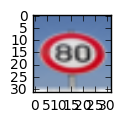

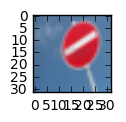

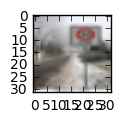

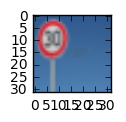

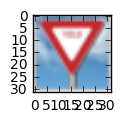

In [96]:
# Plot new images
for index, image in enumerate(new_images):
    #print('Shape: ', image.shape)
    #plt.subplot(222)
    plt.figure(figsize=(1,1))
    plt.imshow(image)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
I choose 5 images, out of which 2 are off center (this is how it looks if you are driving, see 3rd and 4th image)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
Accuracy is 80% but issues are with off-centered images; this is something which has to be taken care of (TODO for myself) as images like #4 will be the real use case (while driving). See output below.

In [118]:
with tf.Session() as sess:
    # Load saved classifier
    sess.run(tf.global_variables_initializer())
    loader = tf.train.import_meta_graph('./TrafficClassifier2.meta')
    loader.restore(sess, tf.train.latest_checkpoint('.'))
    
    # Classify by feeding new test images
    classification = sess.run(tf.argmax(logits, 1), feed_dict={x_unflattened: new_images})
    print()
    print('Classification:')
    print(classification)
    
    # Predict top 5 predictions 
    predictions = sess.run(logits,feed_dict={x_unflattened:new_images})
    top5 = sess.run(tf.nn.top_k(predictions, 5))  
    print()
    print ("Top 5 predictions are:")
    print (top5[1])


Classification:
[ 5 17  1 34 13]

Top 5 predictions are:
[[ 5  2 16  3  7]
 [14 17 10 12 26]
 [11  1  0 12 21]
 [13 34 38 36  5]
 [13 10 42  5 23]]


In [119]:
print(classification)

actual = ['Speed limit (80km/h)','No entry','Speed limit (30km/h)', 'Speed limit (30km/h)', 'Yield']
for index, value in enumerate(classification):
    print ("-------")
    print ("Predicted: " + signal_names_reader(value))
    print ("Actual: " + actual[index])
    
    

[ 5 17  1 34 13]
-------
Predicted: Speed limit (80km/h)
Actual: Speed limit (80km/h)
-------
Predicted: No entry
Actual: No entry
-------
Predicted: Speed limit (30km/h)
Actual: Speed limit (30km/h)
-------
Predicted: Turn left ahead
Actual: Speed limit (30km/h)
-------
Predicted: Yield
Actual: Yield


In [120]:
print (top5[0])# printsprobablities

[[  6708.66748047   3128.14086914   3008.71362305   2596.546875
    1241.53796387]
 [  6427.34667969   4491.98632812   3683.55664062   1064.60144043
      37.32181549]
 [   728.4642334     570.73345947    566.19042969   -121.42193604
    -209.86668396]
 [  4740.70214844   4514.27783203   2215.24462891    879.1730957
     712.52954102]
 [ 19616.7734375    2385.62402344    558.74273682   -493.1312561
   -1417.0098877 ]]


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

Yes the correct predictions appear in the output and it is in top 5.

For #4: Predicted is 34 but actual value should be 13; interestingly this is available in top 5: [13 34 38 36  5].

Classification:
[ 5 17  1 34 13]

Top 5 predictions are:
[[ 5  2 16  3  7]
 [14 17 10 12 26]
 [11  1  0 12 21]
 [13 34 38 36  5]
 [13 10 42  5 23]]


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.